# Ulysses Narrative GMM Turning Points

このノートブックは `scripts/run_report.py` と同等の処理を、Colabで実行する最小版である。


# Ulysses Narrative GMM Turning Points（00: Colab実行＋検定まで）

このノートは、`scripts/run_report.py` と同等の処理を **Colab上で再現可能に実行**し、
生成された `outputs/` を使って **転調点（turning points）候補の統計チェック**まで一気に行う「作業用・再現性優先」ノートです。

---

## このノートで得られるもの（成果物）
- `outputs/preds_all.csv`：各点の `cluster / p_max / entropy / margin` など
- `outputs/events_all.csv`：各点の `transition_type / evidence_ja` など
- `outputs/top_entropy_points_with_evidence.csv`：転調点候補（entropy上位）一覧
- `outputs/transition_type_enrichment_fisher_top_vs_random.csv`：Top vs Random の遷移タイプ富化
- `outputs/margin_tests_top_vs_random.csv`：Top vs Random の margin 分布差（連続量テスト）

> 読み方：上から順に「環境構築 → レポート生成 → 出力読み込み → 検定 → 最後に“候補点一覧”を表示」という流れです。


## 0. セットアップ（迷子防止）
**目的**：Colab上で毎回同じ状態から開始し、実行環境の差によるエラーを潰す。  
**入力/前提**：GitHub repo URL。  
**出力**：`/content/Mokafe-ulysses-narrative-gmm` にclone＋依存導入＋`import narrative_gmm`確認。  
**注意**：ColabはCWDがズレると後続が全部崩れるので、最後に `CWD` を必ず表示する。


In [2]:
# ===== Cell 0: Setup (clone + install + import check) =====
import os, sys, shutil
from pathlib import Path

REPO_URL = "https://github.com/Mokafe/Mokafe-ulysses-narrative-gmm.git"
REPO_DIR = Path("/content/Mokafe-ulysses-narrative-gmm")

# 既存があれば削除してクリーンに（迷い防止）
if REPO_DIR.exists():
    shutil.rmtree(REPO_DIR)

%cd /content
!git clone {REPO_URL}
%cd {REPO_DIR}

# 依存（ログ見えるように -q なし）
!pip install -r requirements.txt

# src を import できるように
sys.path.insert(0, str(Path.cwd() / "src"))

import narrative_gmm
print("OK import narrative_gmm:", narrative_gmm.__file__)
print("CWD:", os.getcwd())
print("TOP:", sorted(os.listdir("."))[:20])


/content
Cloning into 'Mokafe-ulysses-narrative-gmm'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 66 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 804.03 KiB | 7.12 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Mokafe-ulysses-narrative-gmm
OK import narrative_gmm: /content/Mokafe-ulysses-narrative-gmm/src/narrative_gmm/__init__.py
CWD: /content/Mokafe-ulysses-narrative-gmm
TOP: ['.git', 'LICENSE', 'README.md', 'data', 'docs', 'notebooks', 'pyproject.toml', 'requirements.txt', 'scripts', 'src']


## レポート生成（GMM→entropy/margin→outputs出力）
**目的**：以降の解析が依存する `outputs/` 一式を生成する（ここが“土台”）。  
**入力/前提**：`data/sample/ulysses_fixed.json` が存在する。  
**出力**：`outputs/preds_all.csv`, `outputs/events_all.csv`, 図PNG, NPZなど。  
**注意**：ここが完走していないと後続セルは必ず失敗する。まずこのセルを通す。


In [3]:
# ===== Cell 1: Run build_report (generate outputs/) =====
from pathlib import Path
from narrative_gmm.report import build_report, ReportConfig

# 入力（repo内にある前提）
INPUT_PATH = "data/sample/ulysses_fixed.json"
assert Path(INPUT_PATH).exists(), f"missing input: {INPUT_PATH}"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cfg = ReportConfig(
    n_components=8,   # そのままでOK（軽くしたいなら 2 でもOK）
    seed=0,
    alpha=0.05,
    top_k=20,
    context_w=3,
    plots=True
)

paths = build_report(INPUT_PATH, str(OUT_DIR), cfg)
print("build_report done. returned paths:\n", paths)


build_report done. returned paths:
 {'events_all': PosixPath('outputs/events_all.csv'), 'preds_all': PosixPath('outputs/preds_all.csv'), 'boundary_topK': PosixPath('outputs/boundary_top20.csv'), 'boundary_context': PosixPath('outputs/boundary_context.csv'), 'scene_turning_density': PosixPath('outputs/scene_turning_density.csv'), 'scene_cluster_transitions': PosixPath('outputs/scene_cluster_transitions.csv'), 'gmm_params': PosixPath('outputs/gmm_params.npz')}


## 出力確認（ファイルが“ある”ことを先に確認）
**目的**：`preds_all.csv` と `events_all.csv` が生成されているかを目視で確かめる。  
**出力**：`outputs/` のファイル一覧。  
**注意**：Assertionで落とすより、まず一覧を見て状況把握したほうが疲労時に強い。


In [4]:
# ===== Cell 2: List outputs =====
from pathlib import Path

OUT_DIR = Path("outputs")
print("outputs exists:", OUT_DIR.exists())
print("outputs files:", sorted([p.name for p in OUT_DIR.glob("*")]))


outputs exists: True
outputs files: ['boundary_context.csv', 'boundary_top20.csv', 'events_all.csv', 'fig_cluster_timeline.png', 'fig_entropy_timeline.png', 'fig_turning_points.png', 'gmm_params.npz', 'preds_all.csv', 'scene_cluster_transitions.csv', 'scene_turning_density.csv']


## Outputs の存在確認（解析前チェック）
後続セルは `outputs/preds_all.csv` と `outputs/events_all.csv` を前提に動くため、まずファイルが生成済みか確認する。  
ここで落ちたら `build_report` が未完走、または作業ディレクトリ（CWD）がズレている可能性が高い。  
OKならこのまま転調点抽出→検定→本文還元へ進む。


In [5]:
# ===== Cell 3: Outputs sanity check =====
from pathlib import Path

OUT_DIR = Path("outputs")
assert (OUT_DIR/"preds_all.csv").exists(), "preds_all.csv がありません（build_report が完走していません）"
assert (OUT_DIR/"events_all.csv").exists(), "events_all.csv がありません（build_report が完走していません）"
print("OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます")


OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます


## 出力CSVの読み込み（preds / events）
`build_report` が生成した `preds_all.csv`（各点の予測・entropy/margin等）と `events_all.csv`（本文・注釈情報）を読み込む。  
まずファイルの存在を assert で確認し、読み込み後に行列サイズを表示して想定どおり読めているかをチェックする。


In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("outputs")
preds_path  = OUT_DIR / "preds_all.csv"
events_path = OUT_DIR / "events_all.csv"

assert preds_path.exists(), f"missing: {preds_path}（上の build_report を先に実行）"
assert events_path.exists(), f"missing: {events_path}（上の build_report を先に実行）"

preds  = pd.read_csv(preds_path)
events = pd.read_csv(events_path)

print("preds:", preds.shape, "events:", events.shape)


preds: (555, 18) events: (555, 14)


## entropy / margin の時系列プロット
`preds` を `global_step` 順に並べ替え、  
不確実性指標の **entropy** と、最上位2クラスタの確率差である **margin** を時間（global_step）に沿って可視化する。  
スパイク（急変）している箇所が「転調点候補」になりやすい。


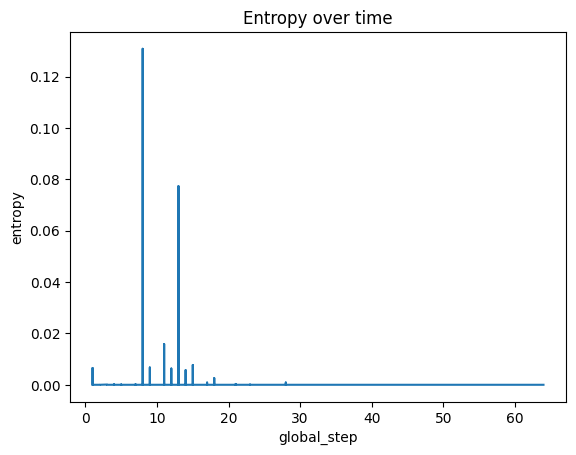

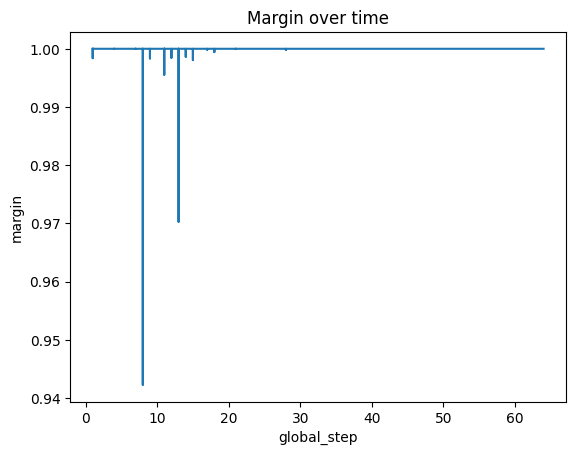

In [7]:
import matplotlib.pyplot as plt

time_col   = "global_step"
entropy_col= "entropy"
margin_col = "margin"

preds = preds.sort_values(time_col).reset_index(drop=True)

plt.figure()
plt.plot(preds[time_col], preds[entropy_col])
plt.title("Entropy over time")
plt.xlabel(time_col); plt.ylabel(entropy_col)
plt.show()

plt.figure()
plt.plot(preds[time_col], preds[margin_col])
plt.title("Margin over time")
plt.xlabel(time_col); plt.ylabel(margin_col)
plt.show()


## 転調点候補（entropy上位K）を本文根拠つきで表示
`events` から evidence 列（日本語優先）を自動検出し、`preds` の entropy 上位K点を抽出する。  
`global_step` で `events` と結合して、各候補点の entropy/margin と evidence を一覧表示する（本文還元の入口）。


In [8]:
# evidence列の自動検出（ja優先）
ev_col = None
for c in ["evidence_ja","evidence","evidence_en","quote","text"]:
    if c in events.columns:
        ev_col = c
        break
print("Detected evidence column:", ev_col)

K = 20
topK = preds.nlargest(K, entropy_col)[[time_col, entropy_col, margin_col]].copy()
merged = topK.merge(events, on=time_col, how="left")

cols = [time_col, entropy_col, margin_col] + ([ev_col] if ev_col else [])
display(merged[cols])


Detected evidence column: evidence_ja


,global_step,entropy,margin,evidence_ja
0,8,0.130792,0.942260,短文応答＋「gloomily」で情動主導。
1,8,0.130792,0.942260,命令形と質問で会話モードへ。
2,8,0.130792,0.942260,時間を越える言い回しで一般化が起きる。
3,8,0.130792,0.942260,移動語（went up / staircase / hall）で場面が切り替わる。
4,8,0.130792,0.942260,「law」から人名・授業描写（High school... teaching）へ移る。
...,...,...,...,...
348,12,0.000056,0.999992,メタ的な導入句で説明モードへ。
349,12,0.000056,0.999992,ラテン語引用で典礼的な言い回し。
350,12,0.000056,0.999992,距離の変化（close quarters）が明示。
351,12,0.000056,0.999992,呼気・火・配置の手順が具体化。


## 転調点候補の前後文脈（±wイベント）を表示
entropy上位10点について、該当 `global_step` の前後 ±w（ここでは3）イベントを取り出し、evidence を並べて表示する。  
単発の点ではなく「前後の流れ」として確認することで、転調がどのような文脈で起きたかを精読しやすくする。


In [9]:
w = 3

events_sorted = events.sort_values(time_col).reset_index(drop=True)
idx_map = {int(t): i for i, t in enumerate(events_sorted[time_col].astype(int).tolist())}

def context_window(t, w=3):
    t = int(t)
    if t not in idx_map:
        return None
    i = idx_map[t]
    lo = max(0, i-w); hi = min(len(events_sorted), i+w+1)
    return events_sorted.iloc[lo:hi].copy()

top10 = preds.nlargest(10, entropy_col)[[time_col, entropy_col, margin_col]].copy()

for _, r in top10.iterrows():
    t = int(r[time_col])
    print("\n" + "="*80)
    print(f"{time_col}={t} | entropy={float(r[entropy_col]):.6g} | margin={float(r[margin_col]):.6g}")
    ctx = context_window(t, w=w)
    if ctx is None:
        print("context not found")
        continue
    show = [time_col] + ([ev_col] if ev_col else [])
    display(ctx[show])



global_step=8 | entropy=0.130792 | margin=0.94226


,global_step,evidence_ja
140,8,命令形と質問で会話モードへ。
141,8,時間を越える言い回しで一般化が起きる。
142,8,定型的な詩行で引用モード。
143,8,整形された反復句で、スクリプトが詩/歌へ切替。
144,9,第三者の動作描写が中心になる。
145,9,食べる動作と感覚語で知覚入力が優勢。
146,9,既知台詞の引用として出現。



global_step=13 | entropy=0.0773125 | margin=0.970272


,global_step,evidence_ja
230,13,行進描写で外界知覚へ。
231,13,形容語の連結で修辞密度が急増。
232,13,aching / void / heart があり emotion と physio を高めた。
233,13,「voice」で他者発話が想起され質問形になる。
234,14,断定的な短文で格言化。
235,14,ダッシュ付き発話で会話が明示される。
236,14,dressed / taste / Fashion により perception と goa...



global_step=11 | entropy=0.0158574 | margin=0.995535


,global_step,evidence_ja
194,11,命令形の社会的発話＋動作注記。
195,11,直接話法・業務的発話。
196,11,外部人物の出現・行為（figure / saluted）。
197,11,「symbol」「cracked lookingglass」で概念化/言語化。
198,12,忘れない・時刻などタスク列挙がある。
199,12,near/afar の反復でアンカーが揺れる。
200,12,「remember」「after my mother’s death」で回想アンカー。



global_step=15 | entropy=0.00769867 | margin=0.99806


,global_step,evidence_ja
266,15,「Reads」「Quickly」「practice」で観察→推測が同一流れ。
267,15,「took a page」「model farm」で紙面テキストへの移行。
268,15,打撃動作→歌唱の行為切替。
269,15,罵倒と命令形が連続し感情強度が上がる。
270,16,「front room」「paper」で場面が具体化。
271,16,reflect/reasoning が主で内的反すうへ移行。
272,16,反復（Watch!）と色・素材語で注意が点滅する。



global_step=9 | entropy=0.00672986 | margin=0.998337


,global_step,evidence_ja
158,9,直前の歌詞を続ける句。
159,9,視覚動詞（saw）と外観記述が中心。
160,9,身体感覚（concussed）と作業（match）が連結。
161,9,疑問文＋「Thumping」反復で作業音が思考に食い込む。
162,10,断片文が連なり、内言の流れが優位。
163,10,罵倒語が連続し、情動強度が上がる対話。
164,10,知覚動詞 perceived により視覚モードが前面化。



global_step=1 | entropy=0.00653156 | margin=0.998392


,global_step,evidence_ja
14,1,発話開始の導入句があり、会話へ切替。
15,1,舞台の場所語が中心で視覚的描写が主。
16,1,聴覚入力（ringing）中心の断片。
17,1,現在の場面を口語で立ち上げている。
18,2,呼称の反復と呼びかけ形式。
19,2,ダッシュと感嘆符で呼びかけの会話入力が明確。
20,2,外界対象（boy/offal）と命令調（Tell him）が同一スパンに並ぶ。



global_step=12 | entropy=0.00631733 | margin=0.998452


,global_step,evidence_ja
212,12,「Somewhere in the east」「Travel」で場所・行為が空想に移行。
213,12,受け取り（handed back）と応答（thanked）が連続。
214,12,メタ的な導入句で説明モードへ。
215,12,呼気・火・配置の手順が具体化。
216,13,引用符的再現（過去発話の再掲）。
217,13,“asked”で会話・質問マーカーが立つ。
218,13,指の探索（forefinger felt）と急な開封（ripping）が同居。



global_step=14 | entropy=0.00568896 | margin=0.998626


,global_step,evidence_ja
248,14,By の反復で移動・列挙。
249,14,ラテン語短句＋発話態度注記。
250,14,嗅覚語（fruitsmelling）と反復動作（lifting）。
251,14,韻律的な詩行で引用モードが優勢。
252,15,formed itself / floated out で連想離脱、場所がlibraryへ。
253,15,動作（strolled/picking）の連続。
254,15,ダッシュ＋発話動詞（said）で会話スイッチ。



global_step=18 | entropy=0.00258982 | margin=0.999435


,global_step,evidence_ja
320,18,文字操作（アナグラム）で音韻遊びが増す。
321,18,固有地名の連鎖で場所アンカー強化。
322,18,身体部位（nails）に視線が向き、観察→評価が生じる。
323,18,足元の砂・歩行の身体感覚が中心に戻る。
324,19,came forward / showing で知覚入力と対人状況が変化。
325,19,tantras 等の語彙で文体・参照密度が変化。
326,19,“says”と疑問形で対話モード。



global_step=28 | entropy=0.000878985 | margin=0.999831


,global_step,evidence_ja
481,28,予見語（foresaw）と身体描写（body reclined）が中心。
482,28,空間移動と光の語で環境アンカーが強く切替。
483,28,断片探索語からSafe!で完了感。
484,28,海上の遠景知覚＋短いラベルで切断。
485,29,会話（—）で一般命題に跳ぶ。
486,29,直後の出来事の評価＋身体語（stitch）。
487,29,未来（夜明け）への時間アンカー移動。


## Top entropy と Random の比較（Fisher検定：あいまい度の差）
entropy上位K点（Top）と、残りから無作為抽出したN点（Random）を作り、  
Random群の margin 中央値をしきい値として「marginが小さい＝あいまい（ambiguous）」を二値化する。  
その後、Top/Random × ambiguous/非ambiguous の2×2表を作り、Fisherの正確確率検定で  
「TopはRandomより“あいまい”になりやすいか」を検定する。


In [10]:
from scipy.stats import fisher_exact

def fisher_2x2_from_groups(df, group_col, flag_col):
    tab = pd.crosstab(df[group_col], df[flag_col])
    tab = tab.reindex(index=["top","random"], columns=[True, False], fill_value=0)
    a = int(tab.loc["top", True]);   b = int(tab.loc["top", False])
    c = int(tab.loc["random", True]);d = int(tab.loc["random", False])
    odds, p = fisher_exact([[a,b],[c,d]], alternative="two-sided")
    return tab, (a,b,c,d,odds,p)

K = 30
N = 30
seed = 0

tmp = preds[[time_col, entropy_col, margin_col]].dropna().copy()

top = tmp.nlargest(K, entropy_col).copy()
rest = tmp.drop(index=top.index)
rnd = rest.sample(n=min(N, len(rest)), random_state=seed).copy()

top["group_norm"] = "top"
rnd["group_norm"] = "random"
tv = pd.concat([top, rnd], axis=0).reset_index(drop=True)

thr = float(np.nanmedian(tv.loc[tv["group_norm"]=="random", margin_col]))
tv["ambiguous_by_margin"] = tv[margin_col] <= thr

tab, (a,b,c,d,odds,p) = fisher_2x2_from_groups(tv, "group_norm", "ambiguous_by_margin")

print(f"threshold: median_random thr={thr:.6f}")
print(tab)
print(f"Top ambiguous率: {a/max(a+b,1):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/max(c+d,1):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")


threshold: median_random thr=1.000000
ambiguous_by_margin  True   False
group_norm                       
top                     30      0
random                  30      0
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 1.000 (30/30)
Fisher two-sided p = 1 | odds ratio = nan


In [11]:
merged_out = OUT_DIR / "turning_topK_with_evidence.csv"
merged[cols].to_csv(merged_out, index=False, encoding="utf-8-sig")
print("Saved:", merged_out)


Saved: outputs/turning_topK_with_evidence.csv


## margin の退化（ほぼ定数）を検出して、検定の恣意性を避ける安全版
`preds_all.csv` から entropy/margin を読み込み、もし margin が未保存なら確率列（p_*/prob_*/resp_*）から再計算する。  
そのうえで **Random 側の margin がほぼ定数（退化）なら、marginベースのFisher検定は情報を持たない**ため明示的に停止する。

退化していない場合のみ、Random の margin 分布から閾値 `thr` を選ぶ。ただし `thr` が最大値に貼り付いて  
`ambiguous_by_margin` が全Trueになる病的ケースを避けるため、閾値を安全化（2番目に大きい値へ落とす等）し、  
比較も `<=` ではなく `<` を用いて二値化を安定させる。  
最後に Top vs Random の2×2表を作り、Fisherの正確確率検定で「あいまい点の比率差」を評価する。


In [12]:
# ============================================================
# Post-check: margin 退化検出 + Fisher(Top vs Random) を安全に回す
#  - thr が max に貼り付く / ambiguous 全True になるケースを回避
#  - それでも退化なら「marginでは検定不能」と明示して止める
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact

OUT_DIR = Path("outputs")
preds_path = OUT_DIR / "preds_all.csv"
assert preds_path.exists(), f"missing: {preds_path}（build_report を先に実行）"

df = pd.read_csv(preds_path)

# ---- 必須列チェック（なければ確率列から再計算を試す）----
prob_cols = [c for c in df.columns if c.startswith(("p_", "prob_", "resp_"))]

if "margin" not in df.columns and prob_cols:
    P = df[prob_cols].to_numpy(float)
    order = np.argsort(-P, axis=1)
    p1 = P[np.arange(len(df)), order[:, 0]]
    p2 = P[np.arange(len(df)), order[:, 1]]
    df["margin"] = p1 - p2

if "entropy" not in df.columns and prob_cols:
    P = df[prob_cols].to_numpy(float)
    df["entropy"] = -(P * np.log(P + 1e-12)).sum(axis=1)

assert "entropy" in df.columns, f"entropy列がありません。columns={list(df.columns)[:50]}"
assert "margin"  in df.columns, f"margin列がありません。columns={list(df.columns)[:50]}"

# ---- Top vs Random の作り方（あなたの流儀）----
TOPN  = 30
RANDN = 30
SEED  = 0

df_sorted = df.sort_values("entropy", ascending=False).reset_index(drop=True)
top = df_sorted.head(TOPN).copy()
remain = df_sorted.iloc[TOPN:].copy()
rnd = remain.sample(n=RANDN, random_state=SEED).copy()

# ---- 退化チェック ----
def is_degenerate_margin(s: pd.Series, eps=1e-9) -> bool:
    s = s.dropna().astype(float)
    return (s.max() - s.min()) < eps

print("margin stats (top):")
print(top["margin"].describe())
print("\nmargin stats (rnd):")
print(rnd["margin"].describe())

if is_degenerate_margin(rnd["margin"], eps=1e-12):
    raise RuntimeError(
        "Random側のmarginが退化（ほぼ定数）しているため、"
        "margin-based Fisher は情報を持ちません。\n"
        "→ 対応: (1) margin定義を見直す (2) モデル設定/正則化を調整 "
        "(3) entropy主基準に切替"
    )

# ---- 閾値の安全化：thr が max に貼り付くなら 2番目の値へ落とす ----
def choose_thr(series: pd.Series, q=0.5) -> float:
    s = series.dropna().astype(float)
    thr = float(s.quantile(q))
    if np.isclose(thr, s.max()):
        uniq = np.unique(np.round(s.to_numpy(), 12))
        if len(uniq) >= 2:
            thr = float(uniq[-2])  # 2番目に大きい値
        else:
            thr = float(thr - 1e-6)
    return thr

thr = choose_thr(rnd["margin"], q=0.5)

both = pd.concat([top.assign(group="top"), rnd.assign(group="random")], ignore_index=True)

# ★ <= だと「thr=1.0貼り付き」で全True化しやすいので strict にする
both["ambiguous_by_margin"] = both["margin"] < thr

a = int(((both.group=="top")    & (both.ambiguous_by_margin)).sum())
b = int(((both.group=="top")    & (~both.ambiguous_by_margin)).sum())
c = int(((both.group=="random") & (both.ambiguous_by_margin)).sum())
d = int(((both.group=="random") & (~both.ambiguous_by_margin)).sum())

odds, p = fisher_exact([[a, b], [c, d]], alternative="two-sided")

print("\n=== Overall 2×2 (ambiguous_by_margin; robust) ===")
print(f"thr = {thr:.12f}  (derived from Random median with safeguard)")
print("Top   :", a, b)
print("Random:", c, d)
print(f"Top ambiguous率: {a/(a+b+1e-12):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/(c+d+1e-12):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")


margin stats (top):
count    30.000000
mean      0.996623
std       0.011611
min       0.942260
25%       0.998829
50%       0.999983
75%       0.999998
max       0.999999
Name: margin, dtype: float64

margin stats (rnd):
count    3.000000e+01
mean     1.000000e+00
std      6.350824e-09
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: margin, dtype: float64

=== Overall 2×2 (ambiguous_by_margin; robust) ===
thr = 0.999999999999  (derived from Random median with safeguard)
Top   : 30 0
Random: 4 26
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.133 (4/30)
Fisher two-sided p = 7.84275e-13 | odds ratio = inf


## margin 分布の差をノンパラで確認（Top は Random より小さいか）
Top群とRandom群の margin を配列に取り出し、分布仮定に依らない2種類の検定で  
「Top の margin が Random より小さい（＝よりあいまい）」という片側仮説を評価する。

- Mann–Whitney U：中央値（順位）の差の検定  
- KS 検定：分布全体が左にシフトしているかの検定

あわせて平均・最小値を出し、差の大きさ（実質的影響）も確認する。


In [13]:
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

m_top = top["margin"].astype(float).to_numpy()
m_rnd = rnd["margin"].astype(float).to_numpy()

u = mannwhitneyu(m_top, m_rnd, alternative="less")   # top < rnd を検定
ks = ks_2samp(m_top, m_rnd, alternative="less")      # 累積分布が左に寄るか

print("Mann–Whitney U:", u)
print("KS test:", ks)
print("top mean/min:", float(m_top.mean()), float(m_top.min()))
print("rnd mean/min:", float(m_rnd.mean()), float(m_rnd.min()))


Mann–Whitney U: MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(3.2394737924483704e-12))
KS test: KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(1.0), statistic_sign=np.int8(-1))
top mean/min: 0.9966233668677054 0.9422600126184284
rnd mean/min: 0.9999999987137381 0.9999999652952394


## margin 分布の可視化と要約統計（効果の大きさチェック）
Top群とRandom群の margin をヒストグラムで重ね描きし、分布の重なり具合を直感的に確認する。  
さらにサンプル数（n）と、中央値・標準偏差を表示して「統計的に有意でも実質差が小さい」ケースを見落とさないための補助チェックを行う。


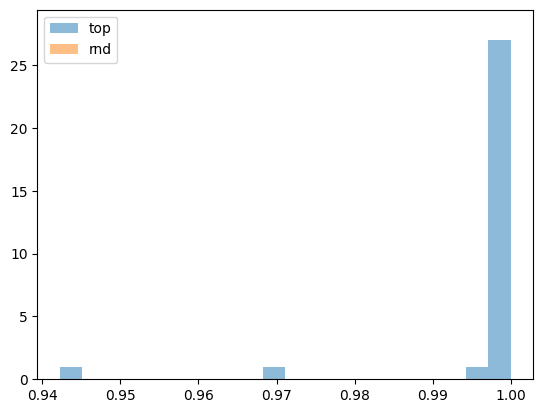

top n=30, rnd n=30
top median/std: 0.999982747542707, 0.011415390166456492
rnd median/std: 1.0, 6.244080085492985e-09


In [14]:
# 分布の可視化
import matplotlib.pyplot as plt
plt.hist(m_top, alpha=0.5, label='top', bins=20)
plt.hist(m_rnd, alpha=0.5, label='rnd', bins=20)
plt.legend()
plt.show()

# サンプルサイズの確認
print(f"top n={len(m_top)}, rnd n={len(m_rnd)}")

# 中央値や分散も確認
print(f"top median/std: {np.median(m_top)}, {np.std(m_top)}")
print(f"rnd median/std: {np.median(m_rnd)}, {np.std(m_rnd)}")

## KS検定の向き（片側仮説の確認）
KS検定は「どちらの分布がどちら側にずれているか」で `alternative` の向きが変わる。  
ここでは「Top のほうが小さい値に寄る（top < rnd）」を確認したいので、片側KSを `alternative="greater"` で実行して結果を出力する。


In [15]:
from scipy.stats import ks_2samp
print("KS (top smaller than rnd) => use alternative='greater'")
print(ks_2samp(m_top, m_rnd, alternative="greater"))


KS (top smaller than rnd) => use alternative='greater'
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(8.455616946072366e-18), statistic_location=np.float64(0.9999993659253608), statistic_sign=np.int8(1))


## 効果量（Cliff’s delta）で「実質差」を確認
Top群とRandom群の margin について、分布の差を **効果量** Cliff’s delta で評価する。  
Cliff’s delta は「TopがRandomより大きい確率 − 小さい確率」で、0に近ければ差が小さく、±1に近いほど分離が強い。  
あわせて両群の中央値も表示し、差の方向と大きさを要約する。


In [16]:
import numpy as np

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    # delta = P(x>y) - P(x<y)
    gt = (x[:,None] > y[None,:]).mean()
    lt = (x[:,None] < y[None,:]).mean()
    return float(gt - lt)

print("Cliff's delta (margin, top vs rnd):", cliffs_delta(m_top, m_rnd))
print("Top median:", float(np.median(m_top)), "Rnd median:", float(np.median(m_rnd)))


Cliff's delta (margin, top vs rnd): -1.0
Top median: 0.999982747542707 Rnd median: 1.0


## 遷移タイプの富化検定（Top vs Random × Fisher）
entropy 上位（Top）と残りからのランダム抽出（Random）を作り、各 transition_type が **Top に偏って多いか** を 2×2 の Fisher 正確確率検定で調べるセルである。  
まず preds と events を共通キーで結合できるよう merge_keys を自動選択し、重複や _x/_y の衝突を避けるため preds 側のテキスト系列を落としてから結合する。  
その後、各タイプごとに「Topに含まれる数 / 含まれない数」と「Randomに含まれる数 / 含まれない数」を比較し、odds_ratio と p 値を表として保存する（サンプル集合も再現性のため同時保存する）。


In [17]:
# ===== Add-on (1 cell): transition_type enrichment + seed sweep + BH-FDR (safe) =====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact
from IPython.display import display  # Notebookでdisplayを安全に使う

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: 精度重視（doc_id + global_step を最優先）
# ------------------------------------------------------------
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],      # 最優先（エピソード内連番の衝突を回避）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],                # 最後手段（潰れうる）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds cols head={list(preds.columns)[:30]}\n"
        f"events cols head={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge（_x/_y回避 + 重複で増減しないように）
# ------------------------------------------------------------
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2_raw = preds.drop(columns=drop_like, errors="ignore")
events2_raw = events.copy()

before_preds = len(preds2_raw)
before_events = len(events2_raw)

preds2  = preds2_raw.drop_duplicates(subset=merge_keys, keep="first")
events2 = events2_raw.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates({merge_keys})")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates({merge_keys})")

# 激減していたら警告（続行はするが、解釈注意）
if len(preds2) < before_preds * 0.8 or len(events2) < before_events * 0.8:
    print("⚠ WARNING: rows dropped a lot. merge_keys may be too weak:", merge_keys)

df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

for col in ["entropy", "margin", "transition_type"]:
    assert col in df.columns, f"{col} missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

# ------------------------------------------------------------
# 2) パラメータ
# ------------------------------------------------------------
TOPN  = 150
RANDN = 150
SEED_LIST = list(range(0, 30))
REP_SEED = 0

# ------------------------------------------------------------
# 3) BH-FDR（Benjamini-Hochberg）
# ------------------------------------------------------------
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    if m == 0:
        return pvals
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(m, dtype=float)
    prev = 1.0
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * m / rank
        prev = min(prev, val)
        q[i] = prev
    out = np.empty(m, dtype=float)
    out[order] = np.clip(q, 0.0, 1.0)
    return out

# ------------------------------------------------------------
# 4) 1回の Top/Random から enrichment
# ------------------------------------------------------------
def enrichment_once(df_in: pd.DataFrame, topn: int, randn: int, seed: int) -> pd.DataFrame:
    df_sorted = df_in.sort_values("entropy", ascending=False).reset_index(drop=True)
    top = df_sorted.head(topn).copy()
    remain = df_sorted.iloc[topn:].copy()
    if len(remain) < randn:
        raise ValueError(f"Not enough remaining rows for RANDN={randn}. remain={len(remain)}")
    rnd = remain.sample(n=randn, random_state=seed).copy()

    types = sorted(pd.concat([top["transition_type"], rnd["transition_type"]], ignore_index=True).unique().tolist())

    rows = []
    for t in types:
        top_has = int((top["transition_type"] == t).sum())
        rnd_has = int((rnd["transition_type"] == t).sum())
        top_no  = int(len(top) - top_has)
        rnd_no  = int(len(rnd) - rnd_has)

        odds, p = fisher_exact([[top_has, top_no], [rnd_has, rnd_no]], alternative="two-sided")

        top_rate = top_has / len(top)
        rnd_rate = rnd_has / len(rnd)
        diff = top_rate - rnd_rate

        rows.append({
            "transition_type": t,
            "top_count": top_has,
            "rnd_count": rnd_has,
            "top_rate": top_rate,
            "rnd_rate": rnd_rate,
            "diff_rate_top_minus_rnd": diff,
            "odds_ratio": (float(odds) if np.isfinite(odds) else np.inf),
            "p_fisher_two_sided": float(p),
        })

    out = pd.DataFrame(rows)
    # ★qは「このseedのこの表の中」でのみ意味があるので、rep用に使う程度に留める
    out["q_bh_fdr_seedlocal"] = bh_fdr(out["p_fisher_two_sided"].to_numpy())
    return out

# ------------------------------------------------------------
# 5) seed sweep（恣意性排除：方向とpの安定性を見る）
# ------------------------------------------------------------
all_runs = []
for seed in SEED_LIST:
    enr = enrichment_once(df, TOPN, RANDN, seed)
    enr["seed"] = seed
    all_runs.append(enr)

all_df = pd.concat(all_runs, ignore_index=True)

# 要約：qは集約せず、diffとpの安定性中心
summary = (
    all_df
    .groupby("transition_type", as_index=False)
    .agg(
        n_runs=("seed", "count"),
        diff_median=("diff_rate_top_minus_rnd", "median"),
        diff_mean=("diff_rate_top_minus_rnd", "mean"),
        pos_rate=("diff_rate_top_minus_rnd", lambda x: float((x > 0).mean())),
        neg_rate=("diff_rate_top_minus_rnd", lambda x: float((x < 0).mean())),
        p_median=("p_fisher_two_sided", "median"),
        p_min=("p_fisher_two_sided", "min"),
        sig_rate_p05=("p_fisher_two_sided", lambda x: float((x < 0.05).mean())),
    )
)

# 「median p」に対して1回だけBH（←報告向けのq）
summary["q_bh_from_median_p"] = bh_fdr(summary["p_median"].to_numpy())

summary = summary.sort_values(
    ["q_bh_from_median_p", "p_median", "diff_median"],
    ascending=[True, True, False]
).reset_index(drop=True)

print(f"\n=== Seed sweep summary (TOPN={TOPN}, RANDN={RANDN}, runs={len(SEED_LIST)}) ===")
display(summary)

# ------------------------------------------------------------
# 6) 代表seed（REP_SEED）の詳細表（これが“表として貼りやすい”）
# ------------------------------------------------------------
rep = all_df[all_df["seed"] == REP_SEED].drop(columns=["seed"]).copy()
rep = rep.sort_values(
    ["q_bh_fdr_seedlocal", "p_fisher_two_sided", "diff_rate_top_minus_rnd"],
    ascending=[True, True, False]
).reset_index(drop=True)

print(f"\n=== Enrichment table (representative seed={REP_SEED}) ===")
display(rep)

# ------------------------------------------------------------
# 7) 保存
# ------------------------------------------------------------
summary_path = OUT_DIR / f"transition_type_enrichment_seed_sweep_summary_TOP{TOPN}_RAND{RANDN}.csv"
all_path     = OUT_DIR / f"transition_type_enrichment_seed_sweep_allruns_TOP{TOPN}_RAND{RANDN}.csv"
rep_path     = OUT_DIR / f"transition_type_enrichment_seed{REP_SEED}_TOP{TOPN}_RAND{RANDN}.csv"

summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
all_df.to_csv(all_path, index=False, encoding="utf-8-sig")
rep.to_csv(rep_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", summary_path)
print(" -", all_path)
print(" -", rep_path)


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates(['doc_id', 'global_step'])
events: 555 -> 555 after drop_duplicates(['doc_id', 'global_step'])
merged df rows: 555

=== Seed sweep summary (TOPN=150, RANDN=150, runs=30) ===


,transition_type,n_runs,diff_median,diff_mean,pos_rate,neg_rate,p_median,p_min,sig_rate_p05,q_bh_from_median_p
0,script_switch,30,-0.093333,-0.093778,0.000000,1.000000,0.043255,0.001263,0.533333,0.389296
1,contrast,30,0.040000,0.043333,1.000000,0.000000,0.321109,0.053502,0.000000,0.954180
2,semantic_association,30,0.026667,0.029556,0.933333,0.033333,0.610825,0.100072,0.000000,0.954180
3,self_censor,30,0.013333,0.010889,0.833333,0.000000,0.622479,0.247492,0.000000,0.954180
4,rumination,30,-0.013333,-0.009778,0.266667,0.666667,0.645565,0.134930,0.000000,0.954180
5,completion,30,0.016667,0.016000,0.766667,0.200000,0.751019,0.178224,0.000000,0.954180
6,phonetic_association,30,-0.006667,-0.005556,0.266667,0.633333,0.769770,0.197668,0.000000,0.954180
7,intrusion,30,0.013333,0.012000,0.633333,0.333333,0.848160,0.186039,0.000000,0.954180
8,goal_task,12,-0.006667,-0.006667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000



=== Enrichment table (representative seed=0) ===


,transition_type,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided,q_bh_fdr_seedlocal
0,script_switch,18,32,0.120000,0.213333,-0.093333,0.502841,0.043255,0.346041
1,contrast,17,10,0.113333,0.066667,0.046667,1.789474,0.225609,0.778820
2,semantic_association,22,15,0.146667,0.100000,0.046667,1.546875,0.292058,0.778820
3,rumination,16,20,0.106667,0.133333,-0.026667,0.776119,0.594539,0.969342
4,intrusion,44,39,0.293333,0.260000,0.033333,1.181422,0.605839,0.969342
5,completion,25,27,0.166667,0.180000,-0.013333,0.911111,0.878910,1.000000
6,phonetic_association,5,4,0.033333,0.026667,0.006667,1.258621,1.000000,1.000000
7,self_censor,3,3,0.020000,0.020000,0.000000,1.000000,1.000000,1.000000



Saved:
 - outputs/transition_type_enrichment_seed_sweep_summary_TOP150_RAND150.csv
 - outputs/transition_type_enrichment_seed_sweep_allruns_TOP150_RAND150.csv
 - outputs/transition_type_enrichment_seed0_TOP150_RAND150.csv


In [25]:
# ===== Add-on (1 cell): transition_type enrichment (Top vs Rest / Fisher) + BH-FDR (seed不要) =====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: 精度重視（doc_id + global_step を最優先）
# ------------------------------------------------------------
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],      # 最優先（エピソード内連番の衝突を回避）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],                 # これしか無い場合の最後手段（データが潰れうる）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds head cols={list(preds.columns)[:30]}\n"
        f"events head cols={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge（_x/_y回避 + 重複で増減しないように）
# ------------------------------------------------------------
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2  = preds.drop(columns=drop_like, errors="ignore").drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

df = preds2.merge(events2, on=merge_keys, how="left")

# 必須列チェック
for col in ["entropy", "transition_type"]:
    assert col in df.columns, f"{col} missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

print("preds:", len(preds), "->", len(preds2), "after drop_duplicates", merge_keys)
print("events:", len(events), "->", len(events2), "after drop_duplicates", merge_keys)
print("merged df rows:", len(df))

# ------------------------------------------------------------
# 2) パラメータ（TopNのみ指定。Restは「残り全部」）
# ------------------------------------------------------------
TOPN = 150   # ←ここだけ調整（例: 80, 150, 200）

df_sorted = df.sort_values("entropy", ascending=False).reset_index(drop=True)
top  = df_sorted.head(TOPN).copy()
rest = df_sorted.iloc[TOPN:].copy()

if len(rest) == 0:
    raise ValueError(f"Restが0件です。TOPN={TOPN} を小さくしてください。")

top["group"]  = "top"
rest["group"] = "rest"

print(f"Top n={len(top)} | Rest n={len(rest)} | Total n={len(df_sorted)}")

# ------------------------------------------------------------
# 3) BH-FDR（Benjamini-Hochberg）関数
# ------------------------------------------------------------
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    if m == 0:
        return pvals
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(m, dtype=float)

    prev = 1.0
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * m / rank
        prev = min(prev, val)
        q[i] = prev

    out = np.empty(m, dtype=float)
    out[order] = np.clip(q, 0.0, 1.0)
    return out

# ------------------------------------------------------------
# 4) transition_type enrichment（2×2 per type）
#    - Top vs Rest（seed不要）
# ------------------------------------------------------------
types = sorted(pd.concat([top["transition_type"], rest["transition_type"]], ignore_index=True).unique().tolist())

rows = []
for t in types:
    top_has  = int((top["transition_type"]  == t).sum())
    rest_has = int((rest["transition_type"] == t).sum())
    top_no   = int(len(top)  - top_has)
    rest_no  = int(len(rest) - rest_has)

    odds, p = fisher_exact([[top_has, top_no], [rest_has, rest_no]], alternative="two-sided")

    top_rate  = top_has / len(top)
    rest_rate = rest_has / len(rest)
    diff = top_rate - rest_rate

    rows.append({
        "transition_type": t,
        "top_count": top_has,
        "rest_count": rest_has,
        "top_rate": top_rate,
        "rest_rate": rest_rate,
        "diff_rate_top_minus_rest": diff,
        "odds_ratio": (float(odds) if np.isfinite(odds) else np.inf),
        "p_fisher_two_sided": float(p),
    })

enr = pd.DataFrame(rows)
enr["q_bh_fdr"] = bh_fdr(enr["p_fisher_two_sided"].to_numpy())

enr = enr.sort_values(
    ["q_bh_fdr", "p_fisher_two_sided", "diff_rate_top_minus_rest"],
    ascending=[True, True, False]
).reset_index(drop=True)

print("\n=== transition_type enrichment (Top vs Rest; Fisher 2×2 per type) ===")
display(enr)

# ------------------------------------------------------------
# 5) 保存（論文/README用）
# ------------------------------------------------------------
out_csv = OUT_DIR / f"transition_type_enrichment_fisher_top_vs_rest_TOP{TOPN}.csv"
enr.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("\nSaved:", out_csv)

# ---- group割当も保存（再現性：Top/Restが固定なのでこれで十分） ----
keep_cols = [c for c in (merge_keys + ["entropy", "transition_type"]) if c in df_sorted.columns]
both_out = pd.concat([top[keep_cols + ["group"]], rest[keep_cols + ["group"]]], ignore_index=True)
both_out.to_csv(OUT_DIR / f"top_vs_rest_assignment_TOP{TOPN}.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR / f"top_vs_rest_assignment_TOP{TOPN}.csv")


merge_keys = ['doc_id', 'global_step']
preds: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
Top n=56 | Rest n=499 | Total n=555

=== transition_type enrichment (Top vs Rest; Fisher 2×2 per type) ===


,transition_type,top_count,rest_count,top_rate,rest_rate,diff_rate_top_minus_rest,odds_ratio,p_fisher_two_sided,q_bh_fdr
0,script_switch,3,101,0.053571,0.202405,-0.148833,0.223052,0.005871,0.052840
1,completion,12,75,0.214286,0.150301,0.063985,1.541818,0.242937,0.790611
2,semantic_association,9,58,0.160714,0.116232,0.044482,1.455979,0.384213,0.790611
3,contrast,6,41,0.107143,0.082164,0.024979,1.340488,0.456191,0.790611
4,rumination,8,54,0.142857,0.108216,0.034641,1.373457,0.499800,0.790611
5,self_censor,1,6,0.017857,0.012024,0.005833,1.493939,0.527074,0.790611
6,phonetic_association,1,19,0.017857,0.038076,-0.020219,0.459330,0.709625,0.912375
7,goal_task,0,1,0.000000,0.002004,-0.002004,0.000000,1.000000,1.000000
8,intrusion,16,144,0.285714,0.288577,-0.002863,0.986111,1.000000,1.000000



Saved: outputs/transition_type_enrichment_fisher_top_vs_rest_TOP56.csv
Saved: outputs/top_vs_rest_assignment_TOP56.csv


In [28]:
# ===== One-cell (revised): Context "mixing" metrics per-doc (no 555->64 collapse) + robust tests =====
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: precision-first（doc_id + global_step を最優先）
# ------------------------------------------------------------
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],   # ★最優先（今回の本命）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],             # 最後の手段（データ潰れのリスク）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds cols head={list(preds.columns)[:30]}\n"
        f"events cols head={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge（_x/_y回避 + 重複で増減しないように）
# ------------------------------------------------------------
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2  = preds.drop(columns=drop_like, errors="ignore")
events2 = events.copy()

before_preds  = len(preds2)
before_events = len(events2)

preds2  = preds2.drop_duplicates(subset=merge_keys, keep="first")
events2 = events2.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates {merge_keys}")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates {merge_keys}")

# 潰れ検出（64化などを強制停止）
if len(preds2) < before_preds * 0.8:
    raise RuntimeError(f"rows collapsed too much: preds {before_preds}->{len(preds2)} (merge_keys={merge_keys})")
if len(events2) < before_events * 0.8:
    raise RuntimeError(f"rows collapsed too much: events {before_events}->{len(events2)} (merge_keys={merge_keys})")

df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

# 必須列
assert "entropy" in df.columns, f"entropy missing. cols head={list(df.columns)[:50]}"
assert "transition_type" in df.columns, f"transition_type missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

# ------------------------------------------------------------
# 2) 並び順：doc境界を跨がない系列にする
# ------------------------------------------------------------
doc_col  = "doc_id" if "doc_id" in df.columns else None
time_col = "global_step" if "global_step" in df.columns else merge_keys[-1]

sort_keys = ([doc_col] if doc_col else []) + [time_col]
sort_keys = [k for k in sort_keys if k is not None and k in df.columns]
if not sort_keys:
    sort_keys = merge_keys[:]  # fallback
print("sort_keys =", sort_keys)

df_seq = df.sort_values(sort_keys).reset_index(drop=True).copy()

# ------------------------------------------------------------
# 3) context metrics（docごとにwindow計算：境界を跨がない）
# ------------------------------------------------------------
def shannon_entropy(counts: np.ndarray) -> float:
    tot = counts.sum()
    if tot <= 0:
        return 0.0
    p = counts / tot
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

W_LIST = [1, 2, 3, 5, 10]  # 恣意性を減らすためスイープ

# 出力格納
for w in W_LIST:
    df_seq[f"ctx_unique_w{w}"] = np.nan
    df_seq[f"ctx_switch_w{w}"] = np.nan
    df_seq[f"ctx_typeH_w{w}"]  = np.nan

# group単位で計算
if doc_col:
    groups = df_seq.groupby(doc_col, sort=False)
else:
    groups = [(None, df_seq)]  # 単一系列として扱う

for _, g in groups:
    idx = g.index.to_numpy()
    types = g["transition_type"].to_numpy()
    n = len(g)

    for w in W_LIST:
        n_unique = np.zeros(n, dtype=int)
        n_switch = np.zeros(n, dtype=int)
        type_H   = np.zeros(n, dtype=float)

        for i in range(n):
            lo = max(0, i - w)
            hi = min(n, i + w + 1)
            seg = types[lo:hi]

            n_unique[i] = int(len(set(seg)))
            n_switch[i] = int(np.sum(seg[1:] != seg[:-1])) if len(seg) >= 2 else 0

            _, cnts = np.unique(seg, return_counts=True)
            type_H[i] = shannon_entropy(cnts.astype(float))

        df_seq.loc[idx, f"ctx_unique_w{w}"] = n_unique
        df_seq.loc[idx, f"ctx_switch_w{w}"] = n_switch
        df_seq.loc[idx, f"ctx_typeH_w{w}"]  = type_H

out_df = df_seq.copy()

# ------------------------------------------------------------
# 4) Spearman + permutation p（doc内シャッフル＝境界尊重）
# ------------------------------------------------------------
def spearman_rho(a: np.ndarray, b: np.ndarray) -> float:
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    ra = ra - ra.mean()
    rb = rb - rb.mean()
    denom = (np.sqrt((ra**2).mean()) * np.sqrt((rb**2).mean())) + 1e-12
    return float((ra * rb).mean() / denom)

def perm_p_spearman_grouped(x: np.ndarray, y: np.ndarray, group_ids: np.ndarray,
                            n_perm=5000, seed=0):
    rng = np.random.default_rng(seed)
    obs = spearman_rho(x, y)

    # groupごとのindexを保持して、yだけをgroup内でシャッフル（doc境界を跨がない）
    uniq = pd.unique(group_ids)
    group_to_idx = {g: np.where(group_ids == g)[0] for g in uniq}

    cnt = 0
    for _ in range(int(n_perm)):
        y_perm = y.copy()
        for g in uniq:
            ix = group_to_idx[g]
            rng.shuffle(y_perm[ix])
        r = spearman_rho(x, y_perm)
        if abs(r) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

N_PERM = 5000
SEED = 0

if doc_col:
    group_ids = out_df[doc_col].astype(str).to_numpy()
else:
    group_ids = np.array(["ALL"] * len(out_df), dtype=object)

rows = []
for w in W_LIST:
    for metric_name in [f"ctx_unique_w{w}", f"ctx_switch_w{w}", f"ctx_typeH_w{w}"]:
        x = out_df[metric_name].to_numpy(dtype=float)
        y = out_df["entropy"].to_numpy(dtype=float)
        rho, p = perm_p_spearman_grouped(x, y, group_ids, n_perm=N_PERM, seed=SEED)
        rows.append({
            "metric": metric_name,
            "w": w,
            "spearman_rho": rho,
            "p_perm_two_sided": p,
            "n_perm": N_PERM,
            "n_points": len(out_df),
            "permute_within": (doc_col if doc_col else "ALL"),
        })

stats = pd.DataFrame(rows).sort_values(["p_perm_two_sided", "metric"]).reset_index(drop=True)

print("\n=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided; within-doc shuffle) ===")
display(stats)

# ------------------------------------------------------------
# 5) save（旧ファイルを潰さないよう suffix 付き）
# ------------------------------------------------------------
out_df_path = OUT_DIR/"context_mixing_metrics_all_points_by_doc.csv"
stats_path  = OUT_DIR/"entropy_vs_context_mixing_perm_spearman_by_doc.csv"
out_df.to_csv(out_df_path, index=False, encoding="utf-8-sig")
stats.to_csv(stats_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", out_df_path)
print(" -", stats_path)

# ------------------------------------------------------------
# 6) preview（代表 w=3：switchが大きい点）
# ------------------------------------------------------------
W_SHOW = 3
cols_show = [c for c in (merge_keys + (["doc_id"] if doc_col else []) + ["entropy","transition_type",
            f"ctx_unique_w{W_SHOW}", f"ctx_switch_w{W_SHOW}", f"ctx_typeH_w{W_SHOW}"]) if c in out_df.columns]
print(f"\n[Preview] highest ctx_switch_w{W_SHOW} points (by-doc):")
display(out_df.sort_values(f"ctx_switch_w{W_SHOW}", ascending=False).head(20)[cols_show])


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
sort_keys = ['doc_id', 'global_step']

=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided; within-doc shuffle) ===


,metric,w,spearman_rho,p_perm_two_sided,n_perm,n_points,permute_within
0,ctx_switch_w1,1,-0.002259,1.0,5000,555,doc_id
1,ctx_switch_w10,10,-0.025759,1.0,5000,555,doc_id
2,ctx_switch_w2,2,-0.001746,1.0,5000,555,doc_id
3,ctx_switch_w3,3,-0.039782,1.0,5000,555,doc_id
4,ctx_switch_w5,5,-0.079823,1.0,5000,555,doc_id
5,ctx_typeH_w1,1,-0.003433,1.0,5000,555,doc_id
6,ctx_typeH_w10,10,-0.080033,1.0,5000,555,doc_id
7,ctx_typeH_w2,2,0.041282,1.0,5000,555,doc_id
8,ctx_typeH_w3,3,0.025727,1.0,5000,555,doc_id
9,ctx_typeH_w5,5,-0.045921,1.0,5000,555,doc_id



Saved:
 - outputs/context_mixing_metrics_all_points_by_doc.csv
 - outputs/entropy_vs_context_mixing_perm_spearman_by_doc.csv

[Preview] highest ctx_switch_w3 points (by-doc):


,doc_id,global_step,doc_id,entropy,transition_type,ctx_unique_w3,ctx_switch_w3,ctx_typeH_w3
7,ulysses_ep01_v1,8,ulysses_ep01_v1,1.934171e-10,contrast,5.0,6.0,1.549826
6,ulysses_ep01_v1,7,ulysses_ep01_v1,1.934171e-10,intrusion,5.0,6.0,1.549826
327,ulysses_ep13_v1,6,ulysses_ep13_v1,1.934171e-10,intrusion,6.0,6.0,1.747868
328,ulysses_ep13_v1,7,ulysses_ep13_v1,1.934171e-10,script_switch,5.0,6.0,1.549826
329,ulysses_ep13_v1,8,ulysses_ep13_v1,1.934171e-10,semantic_association,5.0,6.0,1.549826
330,ulysses_ep13_v1,9,ulysses_ep13_v1,1.934171e-10,completion,5.0,6.0,1.549826
23,ulysses_ep01_v1,24,ulysses_ep01_v1,8.080339e-08,contrast,6.0,6.0,1.747868
24,ulysses_ep01_v1,25,ulysses_ep01_v1,1.936374e-10,rumination,6.0,6.0,1.747868
32,ulysses_ep02_v1,5,ulysses_ep02_v1,1.934171e-10,completion,5.0,6.0,1.475076
519,ulysses_ep18_v1,13,ulysses_ep18_v1,1.934171e-10,rumination,5.0,6.0,1.549826


In [20]:
print(preds.shape, events.shape)
print(preds[merge_keys].nunique())

(555, 18) (555, 14)
doc_id         18
global_step    64
dtype: int64


## 文脈「混ざり具合」指標の作成と、entropy との頑健な相関検定（Top/Randomなし）
各時点の前後ウィンドウ内で、transition_type がどれだけ多様・頻繁に切り替わっているか（unique数・切替回数・タイプ分布エントロピー）を複数の窓幅 w で計算し、全点を対象に entropy との関係を Spearman 相関で評価する。  
p 値は置換（permutation）で推定し、窓幅のスイープ（w=1,2,3,5,10）も行うことで「w を恣意的に選んだ結果」を避ける。  
計算した指標は全点分を CSV に保存し、さらに代表窓幅（例 w=3）で「切替が多い点」をプレビューして、どの箇所が“混ざっている”と判定されたかを確認できるようにする。


In [29]:
# ===== One-cell: Context "mixing" metrics around each point + robust tests (no Top/Random) =====
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ---- merge_keys auto ----
merge_keys = None
key_candidates = [
    ["global_step"],
    ["doc_id", "global_step"],
    ["chapter", "span_id"],
    ["doc_id", "span_id"],
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds head cols={list(preds.columns)[:30]}\n"
        f"events head cols={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ---- avoid _x/_y: drop text/evidence-like columns from preds ----
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2  = preds.drop(columns=drop_like, errors="ignore").drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

df = preds2.merge(events2, on=merge_keys, how="left")

# ---- required cols ----
assert "entropy" in df.columns, f"entropy missing. cols={list(df.columns)[:40]}"
assert "transition_type" in df.columns, f"transition_type missing. cols={list(df.columns)[:40]}"

# ---- sort keys (auto) ----
sort_keys = []
for k in ["doc_id", "work", "episode", "chapter", "global_step", "span_id"]:
    if k in df.columns:
        sort_keys.append(k)
if len(sort_keys) == 0:
    sort_keys = merge_keys[:]  # fallback
print("sort_keys =", sort_keys)

df_seq = df.sort_values(sort_keys).reset_index(drop=True).copy()
df_seq["transition_type"] = df_seq["transition_type"].fillna("NA").astype(str)

types = df_seq["transition_type"].to_numpy()
ent   = df_seq["entropy"].to_numpy(dtype=float)
n = len(df_seq)

# ---- helper: Shannon entropy of categorical counts ----
def shannon_entropy(counts: np.ndarray) -> float:
    tot = counts.sum()
    if tot <= 0:
        return 0.0
    p = counts / tot
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

# ---- compute context metrics for multiple windows w ----
W_LIST = [1, 2, 3, 5, 10]  # スイープして恣意性を減らす（必要なら増やしてOK）

metrics = {}
for w in W_LIST:
    n_unique = np.zeros(n, dtype=int)
    n_switch = np.zeros(n, dtype=int)        # window内の「連続タイプ切替回数」
    type_H   = np.zeros(n, dtype=float)      # window内の transition_type 分布エントロピー

    for i in range(n):
        lo = max(0, i - w)
        hi = min(n, i + w + 1)  # inclusive
        seg = types[lo:hi]

        # unique
        n_unique[i] = int(len(set(seg)))

        # switches (count changes between consecutive elements)
        if len(seg) >= 2:
            n_switch[i] = int(np.sum(seg[1:] != seg[:-1]))
        else:
            n_switch[i] = 0

        # shannon entropy over type counts
        vals, cnts = np.unique(seg, return_counts=True)
        type_H[i] = shannon_entropy(cnts.astype(float))

    metrics[f"ctx_unique_w{w}"] = n_unique
    metrics[f"ctx_switch_w{w}"] = n_switch
    metrics[f"ctx_typeH_w{w}"]  = type_H

ctx = pd.DataFrame(metrics)
out_df = pd.concat([df_seq, ctx], axis=1)

# ---- Spearman correlation + permutation p-value (two-sided) ----
def spearman_rho(a: np.ndarray, b: np.ndarray) -> float:
    # rank-transform (average ranks)
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    # Pearson on ranks
    ra = ra - ra.mean()
    rb = rb - rb.mean()
    denom = (np.sqrt((ra**2).mean()) * np.sqrt((rb**2).mean())) + 1e-12
    return float((ra * rb).mean() / denom)

def perm_p_spearman(x: np.ndarray, y: np.ndarray, n_perm=5000, seed=0):
    rng = np.random.default_rng(seed)
    obs = spearman_rho(x, y)
    cnt = 0
    for _ in range(int(n_perm)):
        y_perm = y.copy()
        rng.shuffle(y_perm)
        r = spearman_rho(x, y_perm)
        if abs(r) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

N_PERM = 5000
SEED = 0

rows = []
for w in W_LIST:
    for metric_name in [f"ctx_unique_w{w}", f"ctx_switch_w{w}", f"ctx_typeH_w{w}"]:
        x = out_df[metric_name].to_numpy(dtype=float)
        y = out_df["entropy"].to_numpy(dtype=float)
        rho, p = perm_p_spearman(x, y, n_perm=N_PERM, seed=SEED)
        rows.append({
            "metric": metric_name,
            "w": w,
            "spearman_rho": rho,
            "p_perm_two_sided": p,
            "n_perm": N_PERM,
            "n_points": len(out_df),
        })

stats = pd.DataFrame(rows).sort_values(["p_perm_two_sided", "metric"]).reset_index(drop=True)

print("\n=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided) ===")
display(stats)

# ---- save ----
out_df_path = OUT_DIR/"context_mixing_metrics_all_points.csv"
stats_path  = OUT_DIR/"entropy_vs_context_mixing_perm_spearman.csv"
out_df.to_csv(out_df_path, index=False, encoding="utf-8-sig")
stats.to_csv(stats_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", out_df_path)
print(" -", stats_path)

# ---- (optional) show top few points with highest mixing for a representative w ----
W_SHOW = 3
cols_show = [c for c in (merge_keys + ["entropy","transition_type", f"ctx_unique_w{W_SHOW}", f"ctx_switch_w{W_SHOW}", f"ctx_typeH_w{W_SHOW}"]) if c in out_df.columns]
print(f"\n[Preview] highest ctx_switch_w{W_SHOW} points:")
display(out_df.sort_values(f"ctx_switch_w{W_SHOW}", ascending=False).head(15)[cols_show])


merge_keys = ['global_step']
sort_keys = ['global_step']

=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided) ===


,metric,w,spearman_rho,p_perm_two_sided,n_perm,n_points
0,ctx_unique_w2,2,0.205106,0.098180,5000,64
1,ctx_unique_w3,3,0.188856,0.135973,5000,64
2,ctx_typeH_w2,2,0.164770,0.198360,5000,64
3,ctx_switch_w2,2,0.152194,0.223755,5000,64
4,ctx_typeH_w3,3,0.146066,0.247351,5000,64
5,ctx_switch_w1,1,0.141715,0.263347,5000,64
6,ctx_unique_w1,1,0.110095,0.383323,5000,64
7,ctx_unique_w5,5,0.107674,0.403119,5000,64
8,ctx_typeH_w1,1,0.097814,0.441312,5000,64
9,ctx_typeH_w5,5,0.046489,0.714457,5000,64



Saved:
 - outputs/context_mixing_metrics_all_points.csv
 - outputs/entropy_vs_context_mixing_perm_spearman.csv

[Preview] highest ctx_switch_w3 points:


,global_step,entropy,transition_type,ctx_unique_w3,ctx_switch_w3,ctx_typeH_w3
3,4,1.193538e-07,contrast,4,6,1.277034
6,7,1.934171e-10,intrusion,5,6,1.549826
5,6,1.934171e-10,semantic_association,5,6,1.549826
4,5,1.934171e-10,script_switch,4,6,1.351784
7,8,1.934171e-10,contrast,5,6,1.549826
30,31,1.934171e-10,completion,6,6,1.747868
29,30,7.584286e-10,script_switch,5,6,1.549826
28,29,1.934171e-10,rumination,6,6,1.747868
24,25,1.936374e-10,rumination,6,6,1.747868
25,26,1.934171e-10,intrusion,6,6,1.747868


## preds と events を安全に結合する（キー自動判定＋列名衝突回避）
preds_all.csv と events_all.csv を読み込み、両方に共通して存在する結合キー（例：global_step など）を候補から自動で選んで merge する。  
merge 時に `_x/_y` が大量に増えるのを避けるため、preds 側の本文・evidence・transition_type 系の列は事前に落とし、さらにキー重複があると行数が増えるので双方で重複を軽く除去してから結合する。  
最後に、結合後データ df の列の先頭と行数を出して、merge が意図通り（膨張していない／列が揃っている）かを確認する。


In [30]:
from pathlib import Path
import pandas as pd

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# --- 0) merge_keys を「精度優先」で自動決定 ---
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],   # ★最優先（今回の本命：衝突回避）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],             # 最後の手段（単独は縮退リスク大）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break

if merge_keys is None:
    raise ValueError(
        "preds/events で共通キーが見つかりません。\n"
        f"preds cols head: {list(preds.columns)[:30]}\n"
        f"events cols head: {list(events.columns)[:30]}"
    )

print("merge_keys =", merge_keys)

# --- 1) _x/_y を避けるため preds 側の本文系列を落とす ---
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2 = preds.drop(columns=drop_like, errors="ignore")

# --- 2) dedup（縮退を検知する） ---
before_preds  = len(preds2)
before_events = len(events)

preds2  = preds2.drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates {merge_keys}")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates {merge_keys}")

# ★縮退チェック（必要なら閾値は調整）
if len(preds2) < before_preds * 0.9:
    print("⚠ WARNING: preds が大きく減っています。merge_keys が弱い可能性:", merge_keys)
if len(events2) < before_events * 0.9:
    print("⚠ WARNING: events が大きく減っています。merge_keys が弱い可能性:", merge_keys)

# --- 3) merge（膨張チェックもする） ---
df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

# ★膨張チェック（通常は増えないのが理想）
if len(df) > max(len(preds2), len(events2)) * 1.05:
    print("⚠ WARNING: merge で行数が増えています（キー重複の可能性）。merge_keys を見直してください。")

print("df columns head:", list(df.columns)[:30])


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
df columns head: ['doc_id', 'work_x', 'episode_x', 'global_step', 'time_anchor_x', 'place_anchor_x', 'anchor_strength_x', 'status_x', 'label_x', 'cluster', 'p_max', 'entropy', 'margin', 'work_y', 'episode_y', 'span_text_en', 'span_text_ja', 'evidence_en', 'evidence_ja', 'transition_type', 'time_anchor_y', 'place_anchor_y', 'anchor_strength_y', 'status_y', 'label_y']


## Top entropy 点（転調点候補）の抽出と本文（evidence）の付与
df から entropy が高い上位 TOPN 点を「転調点候補」として取り出し、読める形にするために evidence 列（日本語優先）を自動検出して一緒に表示・保存する。  
保存先は `outputs/top_entropy_points_with_evidence.csv` で、後続の「本文還元（どの箇所が転調点か）」にそのまま使える一覧になる。


In [31]:
# Top entropy 抽出
evidence_col = None
for c in ["evidence_ja","evidence_en","evidence","quote","text","raw_text"]:
    if c in df.columns:
        evidence_col = c
        break

assert "entropy" in df.columns and "margin" in df.columns
assert evidence_col is not None, "evidence列が見つかりません（events_all.csv 側の列を確認してください）"

TOPN = 30
top = df.sort_values("entropy", ascending=False).head(TOPN).copy()

show_cols = [c for c in (merge_keys + ["entropy","margin","transition_type", evidence_col]) if c in top.columns]
top_out = top[show_cols].copy()

display(top_out)
top_out.to_csv(OUT_DIR/"top_entropy_points_with_evidence.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR/"top_entropy_points_with_evidence.csv")


,doc_id,global_step,entropy,margin,transition_type,evidence_ja
63,ulysses_ep03_v1,8,0.130792,0.942260,completion,時間を越える言い回しで一般化が起きる。
334,ulysses_ep13_v1,13,0.077312,0.970272,rumination,aching / void / heart があり emotion と physio を高めた。
91,ulysses_ep04_v1,11,0.015857,0.995535,completion,「eyelids」「warmth」で身体感覚＋「breadvan」で外界入力へ。
336,ulysses_ep13_v1,15,0.007699,0.998060,intrusion,反復と感嘆符があり emotion と syntax_break を上げた。
116,ulysses_ep05_v1,9,0.006730,0.998337,completion,具体動作（took/unfolded/rolled）が連続する。
56,ulysses_ep03_v1,1,0.006532,0.998392,intrusion,視覚入力を「思考」として扱う表現がある。
307,ulysses_ep12_v1,12,0.006317,0.998452,completion,turned into で移動、corner で位置が定まる。
13,ulysses_ep01_v1,14,0.005689,0.998626,completion,焦点語「offence」「me」で自己へ収束。
98,ulysses_ep04_v1,18,0.002590,0.999435,completion,「horror」「seared」で情動、「hurrying homeward」で行為に切替。
163,ulysses_ep06_v1,28,0.000879,0.999831,contrast,礼の語と評価語で内言の情動が出る。


Saved: outputs/top_entropy_points_with_evidence.csv


In [24]:
merged_out = OUT_DIR / "turning_topK_with_evidence.csv"
merged[cols].to_csv(merged_out, index=False, encoding="utf-8-sig")
print("Saved:", merged_out)


Saved: outputs/turning_topK_with_evidence.csv
